In [3]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

## current script object
thismodule = sys.modules[__name__]

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'casestudy', 'settings', 'fcns_load_RCEMIP_SAM', 'PrecipGrid', 'fcns_multiscale_extremes']


In [156]:
import conditionalstats as cs
from fcns_multiscale_extremes import *
from plot2D import *

In [6]:
region = 'tropics'
path_regrid = os.path.join(DIR_DYAMOND_PROCESSED,region,'SAM','regridded')

In [7]:
figdir = os.path.join(os.path.dirname(workdir),'figures/multiscale_extremes',region)
os.makedirs(figdir,exist_ok=True)

In [8]:
prec_data = xr.open_dataset(os.path.join(path_regrid,'Prec.nc'))

In [70]:
prec_data

<xarray.Dataset>
Dimensions:            (days: 22, lat: 1554, lat_global: 60, lon: 9216, lon_global: 360)
Coordinates:
  * lat                (lat) float32 -30.0 -29.96 -29.92 ... 29.92 29.96 30.0
  * lon                (lon) float32 0.01953 0.05859 0.09766 ... 359.9 360.0
  * lat_global         (lat_global) int64 0 1 2 3 4 5 6 ... 53 54 55 56 57 58 59
  * lon_global         (lon_global) int64 0 1 2 3 4 5 ... 355 356 357 358 359
  * days               (days) int64 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21
Data variables:
    pixel_surf         (lat, lon) float64 10.17 10.17 10.17 ... 10.17 10.17
    global_pixel_surf  (lat_global, lon_global) float64 1.181e+04 ... 1.181e+04
    mean_Prec          (lat_global, lon_global, days) float64 0.00787 ... 0.0...
    max_Prec           (lat_global, lon_global, days) float64 2.092 ... 0.6077

In [71]:
dim_t = 2

In [10]:
# Single-variable distributions
mean_prec = prec_data.mean_Prec.values
dist_mean_prec = cs.Distribution(name="DYAMOND mean precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_mean_prec.computeDistribution(sample = mean_prec)
dist_mean_prec.storeBinLocations(sample = mean_prec,sizemax=1000)

max_prec = prec_data.max_Prec.values
dist_max_prec = cs.Distribution(name="DYAMOND max precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_max_prec.computeDistribution(sample = max_prec)
dist_max_prec.storeBinLocations(sample = max_prec,sizemax=1000)

# Joint distribution
jdist_prec = cs.JointDistribution(name='Prec mean vs. max',distribution1=dist_mean_prec, distribution2=dist_max_prec)
jdist_prec.computeDistribution(sample1=mean_prec,sample2=max_prec)
jdist_prec.computeNormalizedDensity(sample1=mean_prec,sample2=max_prec)
digit3D_mean, digit3D_max = jdist_prec.computeConditionalLocations(sample1=mean_prec,sample2=max_prec)

In [11]:
def jointDigit(digit3D_1,digit3D_2):
    
    digit3D_joint = 100*digit3D_1 + digit3D_2
    
    return digit3D_joint

digit3D_joint = jointDigit(digit3D_mean,digit3D_max)

In [14]:
# indices/digits in joint distribution space
dig_1D = np.digitize(dist_max_prec.ranks,dist_max_prec.ranks)
dig_2D_i, dig_2D_j = np.meshgrid(dig_1D,dig_1D)
dig_2D = jointDigit(*np.meshgrid(dig_1D,dig_1D))

In [164]:
#-- create masks for a region on joint distribution
# mask a square over 90th percentile
mask_jdist_90_90 = np.outer(dist_mean_prec.ranks >= 90,dist_max_prec.ranks >= 90)
mask_jdist_90_0 = np.outer(dist_mean_prec.ranks >= 90,dist_max_prec.ranks >= 0)
mask_jdist_0_90 = np.outer(dist_mean_prec.ranks >= 0,dist_max_prec.ranks >= 90)
mask_jdist_below_90 = np.outer(dist_mean_prec.ranks < 90,dist_max_prec.ranks < 90)
# mask above diagonal
mask_lower_diag = dig_2D_i <= dig_2D_j
mask_upper_diag = dig_2D_i > dig_2D_j
# mask correlated and anticorrelated
Z_norm = jdist_prec.norm_density
Z_count = jdist_prec.bincount
mask_corr = Z_norm > 1
mask_anticorr = np.logical_and(Z_norm < 1,Z_count>0)
# mask left of branch 1
mask_branch1 = np.logical_and(mask_upper_diag,mask_anticorr)
mask_branch1_90 = np.logical_and(mask_branch1,mask_jdist_0_90)
# mask below to branch 2
mask_branch2 = np.logical_and(mask_lower_diag,mask_anticorr)
mask_branch2_90 = np.logical_and(mask_branch2,mask_jdist_90_0)
# mask_middle, upper and lower diagonal
mask_coloc_c = np.logical_and(mask_upper_diag,mask_corr)
mask_coloc_c_90 = np.logical_and(mask_coloc_c,mask_jdist_0_90)
mask_coloc_ac = np.logical_and(mask_lower_diag,mask_corr)
mask_coloc_ac_90 = np.logical_and(mask_coloc_ac,mask_jdist_90_0)

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked eleme

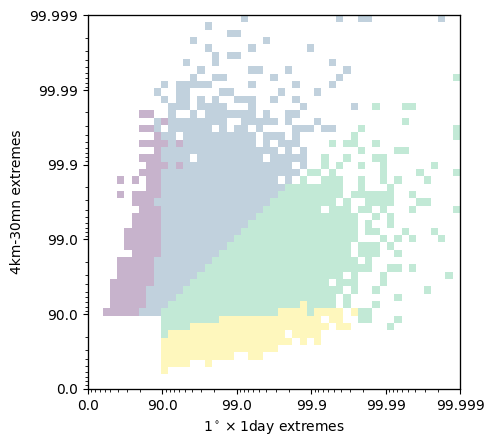

In [150]:
# create mask

mask_show = 1.*mask_branch1_90 + 2.*mask_coloc_c_90 + 3.*mask_coloc_ac_90 + 4.*mask_branch2_90
mask_show[mask_show == 0] = np.nan

# Show

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4.8,4.85))

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")

ax_show.imshow(mask_show.T,alpha=0.3,origin='lower')
ax_show.set_xticks([])
ax_show.set_yticks([])

plt.savefig(os.path.join(figdir,'Y_branches_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

/home/bfildier/analyses/explore-multiscale-extremes/functions/fcns_multiscale_extremes.py:11: RuntimeWarning: overflow encountered in exp
  if cont.__class__ is list:
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked 

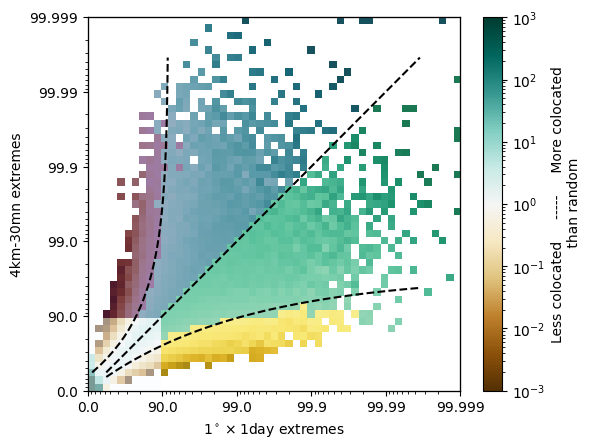

In [176]:
# Show normalized density with branches fitted -- black

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4.8,4.85))

Z = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# -- Density
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = measure.find_contours(Z, 1)

# -- Masks multiscale categories
mask_categories = mask_show = 1.*mask_branch1_90 + 2.*mask_coloc_c_90 + 3.*mask_coloc_ac_90 + 4.*mask_branch2_90
mask_categories[mask_categories==0] = np.nan
ax_show.imshow(mask_categories.T,alpha=0.5,origin='lower')

# cornoer below 90th percentile
ma_no_ext = np.ma.masked_where(mask_jdist_below_90 == 0, mask_jdist_below_90)
ax_show.imshow(ma_no_ext.T,alpha=0.5,origin='lower',cmap='Blues')

# -- Branches
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show branches
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# show 1-1 line
ax_show.plot(x_branch_2,x_branch_2,'k--')

# cb = fig.colorbar(pcm, ax=ax_show)
# # cb.set_label('Normalized density')
# cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_w_masks_on_max_vs_mean_prec_extremes_Y_branches.pdf'),bbox_inches='tight')

In [130]:
# for any bin, find set of x,y,t points
def get_mask_yxt(digit_1,digit_2,digit3D_1,digit3D_2):
    
    dj = jointDigit(digit_1,digit_2)
    dj_3D = jointDigit(digit3D_1,digit3D_2)
    
    return dj_3D == dj

# for a full joint-dist mask, find set of x,y,t points
def get_mask_yxt_from_mask_jdist(mask_jdist,digits3D_1,digits3D_2):
    
    mask_yxt_all = False
    i_j_mask = np.where(mask_jdist)
    for i,j in zip(i_j_mask[0],i_j_mask[1]):
        
        mask_yxt = get_mask_yxt(i,j,digits3D_1,digits3D_2)
        mask_yxt_all = np.logical_or(mask_yxt_all,mask_yxt)
    
    return mask_yxt_all

def getCoordValues(data,coordname):
    
    xname = coordname

    x_native = data[xname].values
    x_bnds = np.round(x_native[0],2), np.round(x_native[-1],2)
    x_regrid = data['%s_global'%xname].values
    Nx = len(x_regrid)
    
    dx = np.diff(x_bnds)/Nx

    edges = np.arange(x_bnds[0],x_bnds[1]+dx,dn)
    centers = np.convolve(edges,[0.5,0.5],'valid')

    return centers

def getCoords2D(dataset,slice_lon,slice_lat):
    
    
    # extract coordinates
    lat_1D = getCoordValues(dataset,'lat')
    lon_1D = getCoordValues(dataset,'lon')

    # compute 2D meshgrid of coordinates
    lonarray,latarray = np.meshgrid(lon_1D,lat_1D)
    
    return lonarray,latarray


# test 1 joint bin
mask_yxt_20_30 = get_mask_yxt(20,30,digit3D_mean,digit3D_max)
count_yxt_20_30 = np.sum(mask_yxt_20_30,axis=dim_t)

# plt.imshow(count_tyz_20_30.T)

# test 90-90 mask
mask_yxt_90_90 = get_mask_yxt_from_mask_jdist(mask_jdist_90_90,digit3D_mean,digit3D_max)
count_yxt_90_90 = np.sum(mask_yxt_90_90,axis=dim_t)

In [146]:
## image
# cmap = plt.cm.bone_r
# cmap = plt.cm.Blues
cmap = plt.cm.afmhot_r
# cmap_mcs = plt.cm.get_cmap('rainbow', 10)
cmap_mcs = plt.cm.get_cmap('Accent', 10)
# clim = (10,70)
lon_lim = (0,360)
lat_lim = (-30,30)
slice_lat = slice(*lat_lim)
slice_lon = slice(*lon_lim)

# compute figure size
dlon = np.diff(lon_lim)[0] % 360
if dlon == 0: dlon = 360
dlat = np.diff(lat_lim)[0]
Lx_fig = 15
Lx_cbar = 1.5
Ly_title = 1
Ly_fig = (Lx_fig-Lx_cbar)/dlon*dlat + Ly_title
print('figure size =',Lx_fig,Ly_fig)

def makeMap(mask_yxt):

    # initialize figure
    fig = plt.figure(figsize=(Lx_fig,Ly_fig))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

    # coords
    lonarray_dyamond,latarray_dyamond = getCoords2D(prec_data,slice_lon,slice_lat)            
    # data
    Z = np.sum(mask_yxt,axis=dim_t) # count
    Next = np.sum(Z)
    # show
    # im = ax.pcolormesh(np.ravel(lonarray_dyamond),np.ravel(latarray_dyamond),np.ravel(Z),transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
    im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,Z,transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
    # im.set_clim(*clim)

    ax.coastlines('110m')
    ax.gridlines()
    ax.text(0.01,0.05,"N = %d"%Next,transform=ax.transAxes)
    
    # Colorbar
    x,y,w,h = ax.get_position().bounds
    dx = w/60
    cax = plt.axes([x+w+1.5*dx,y,dx,h])
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel('Bincount (#)')

    return ax

figure size = 15 3.25


Convective only


/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


Mostly convective


/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


Mostly mesoscale


/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


Mesoscale only


/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


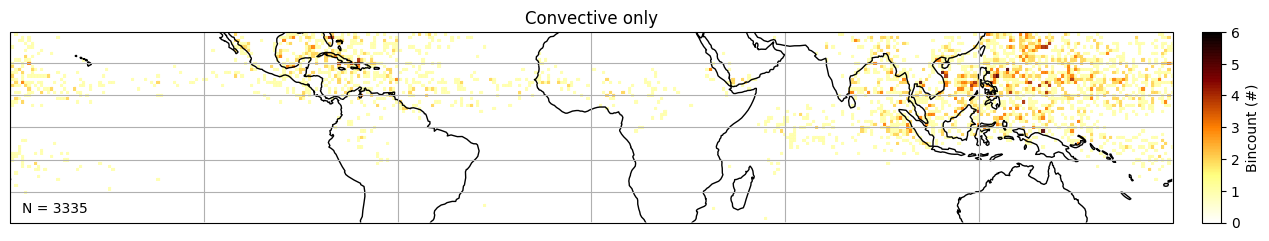

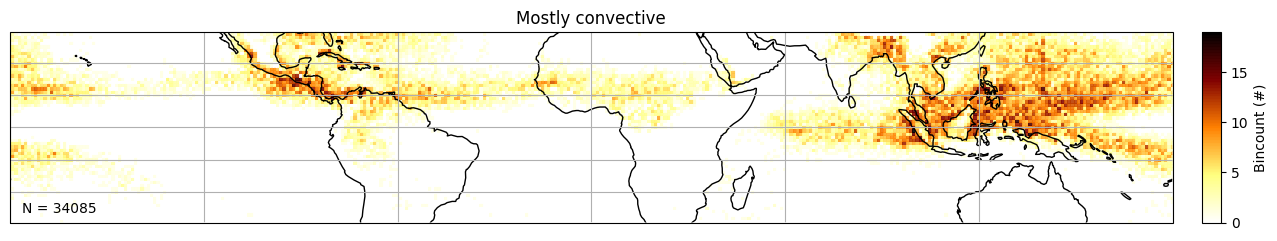

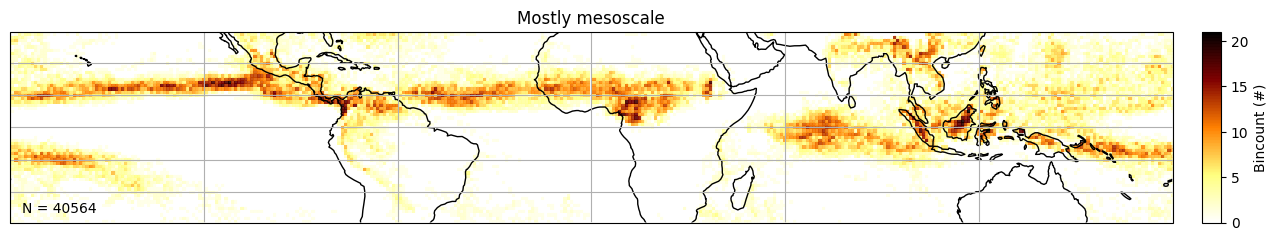

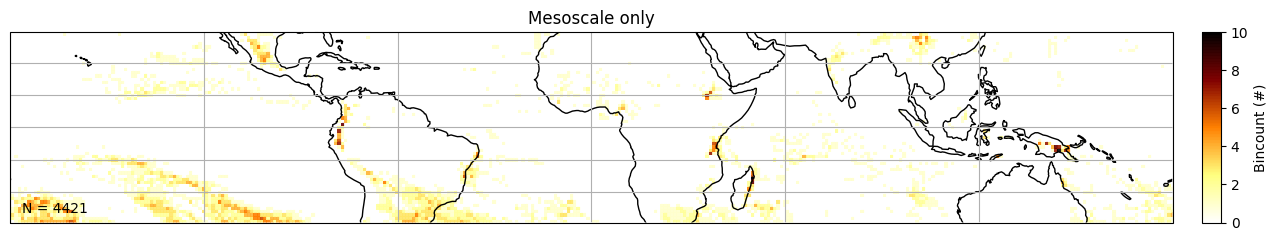

In [149]:
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

mask_all = mask_branch1_90,mask_coloc_c_90,mask_coloc_ac_90,mask_branch2_90
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'

for mask,mask_name,mask_label in zip(mask_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_yxt = get_mask_yxt_from_mask_jdist(mask,digit3D_mean,digit3D_max)
    ax = makeMap(mask_yxt)
    ax.set_title(mask_name)
    
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.pdf'%(mask_label)),bbox_inches='tight')
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

In [28]:
LLS_data = xr.open_dataset(os.path.join(path_regrid,'LLS.nc'))['mean_LLS']

In [88]:
cond_varids = 'CWP', 'IWP', 'LHF', 'LLS', 'LLSU', 'LLSV', 'OM850', 'Prec', 'PW', 'RH500', 'RH850', 'SHF', 'T2mm', 'U10m', 'V10m'

cond_dict = dict()

for cvarid in cond_varids:
    
    cond_dict[cvarid] = {}
    
    print(cvarid)
    cond_data_mean = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['mean_%s'%cvarid]
    cond_data_max = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['max_%s'%cvarid]
    
    cond_dict[cvarid]['mean'] = jdist_prec.computeConditionalDataOverDensity(sample1=mean_prec,sample2=max_prec,data=cond_data_mean.values)
    cond_dict[cvarid]['max'] = jdist_prec.computeConditionalDataOverDensity(sample1=mean_prec,sample2=max_prec,data=cond_data_max.values)
    cond_dict[cvarid]['units'] = None
    
    # clear memory
    del cond_data_mean, cond_data_max
    gc.collect()
    

CWP
IWP
LHF
LLS
LLSU
LLSV
OM850
Prec
PW
RH500
RH850
SHF
T2mm
U10m
V10m


In [89]:
# Show conditional values

for cvarid in cond_varids:
    
    for func in 'mean','max':
    
        Z_nd = jdist_prec.norm_density.T
        Z = cond_dict[cvarid][func].T

        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

        title = '%s'%cvarid
        scale ='linear'
        vbds = (None, None)
        cmap = plt.cm.viridis

        ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

        # -- Frame
        ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
        ax.set_xlabel(r"1$^\circ\times 1$day extremes")
        ax.set_ylabel(r"4km-30mn extremes")
        ax.set_title(title)

        # -- Conditional mean values
        pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)


        # -- Branches
        cont = measure.find_contours(Z_nd, 1)    
        N = 60
        # fit
        popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
        x_branch_2 = y_branch_1 = np.linspace(2,45,45)
        y_branch_2 = func(x_branch_2,*popt_2)
        x_branch_1 = func(y_branch_1,*popt_1)

        # show
        ax_show.plot(x_branch_1,y_branch_1,'k--')
        ax_show.plot(x_branch_2,y_branch_2,'k--')

        cb = fig.colorbar(pcm, ax=ax_show)
        # cb.set_label('Normalized density')
        cb.set_label('')

        plt.savefig(os.path.join(figdir,'%s_%s_on_max_vs_mean_prec_extremes.pdf'%(cvarid,func)),bbox_inches='tight')
        plt.close()

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked eleme

# LANDMASK

In [68]:
# LANDMASK - distribution of land, distribution of ocean separately

cvarid = 'LANDMASK'

# landmask data
landmask_rg = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['mean_%s'%cvarid]
island = landmask_rg > 0.5
isocean = landmask_rg < 0.5
Nland = np.sum(island).values
Nocean = np.sum(isocean).values
Ntot = np.size(island)

# Count
bincount_land = jdist_prec.computeConditionalSum(sample1=mean_prec,sample2=max_prec,data=island.values)
bincount_ocean = jdist_prec.computeConditionalSum(sample1=mean_prec,sample2=max_prec,data=isocean.values)


In [69]:
Nland, Nocean, Ntot, Nland+Nocean

(array(121198), array(354002), 475200, 475200)

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


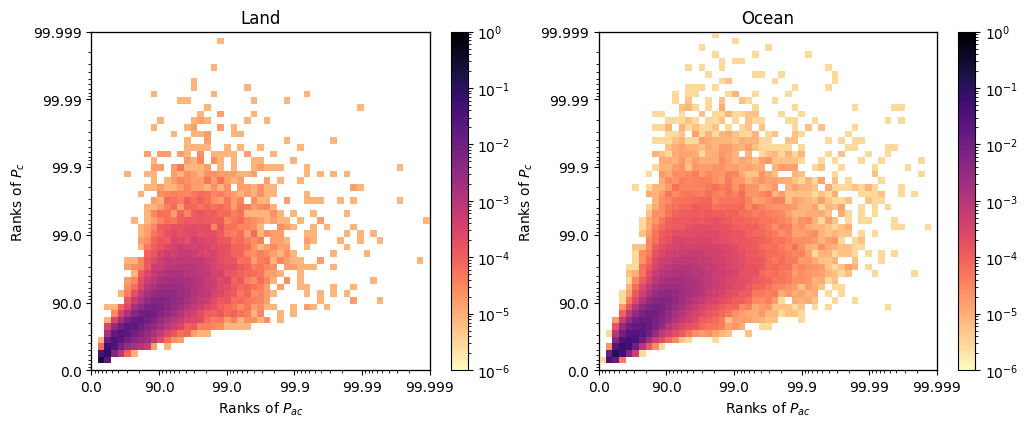

In [65]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4.4))

Z1 = bincount_land.T/Nland
Z2 = bincount_ocean.T/Nocean

titles = 'Land', 'Ocean'
scales = 'log','log'
vbounds = (1e-6,1),(1e-6,1)
cmaps = plt.cm.magma_r, plt.cm.magma_r

for ax,Z,title,scale,vbds,cmap in zip(axs,(Z1,Z2),titles,scales,vbounds,cmaps):

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel("Ranks of $P_{ac}$")
    ax.set_ylabel("Ranks of $P_{c}$")
    ax.set_title(title)

    # Content
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
    fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'number_over_land_and_ocean_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

/tmp/ipykernel_3105530/979033929.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:3: RuntimeWarning: invalid value encountered in true_divide
  Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:4: RuntimeWarning: divide by zero encountered in true_divide
  Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:4: RuntimeWarning: invalid value encountered in true_divide
  Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildi

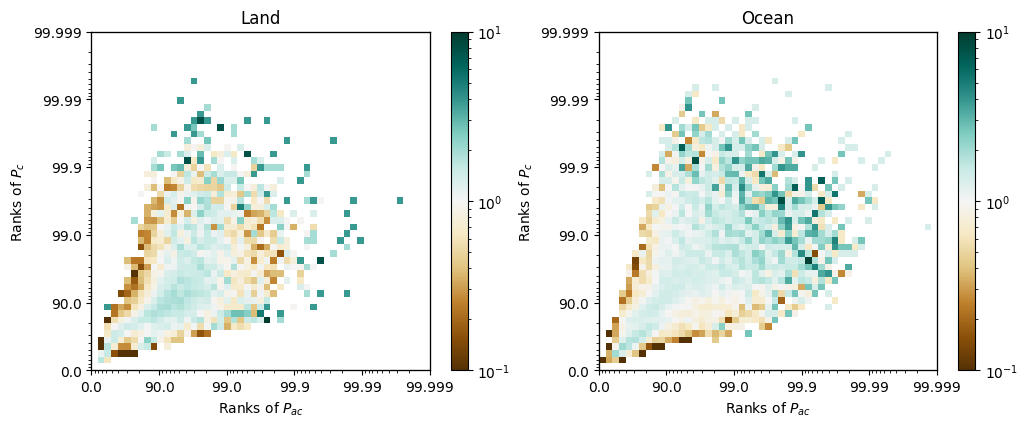

In [70]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4.4))

Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)

titles = 'Land', 'Ocean'
scales = 'log','log'
# vbounds = (1,1e4),(1e-3,1e3)
vbounds = (1e-1,1e1),(1e-1,1e1)
# cmaps = plt.cm.magma_r, plt.cm.magma_r
cmaps = plt.cm.BrBG, plt.cm.BrBG

for ax,Z,title,scale,vbds,cmap in zip(axs,(Z1,Z2),titles,scales,vbounds,cmaps):

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel("Ranks of $P_{ac}$")
    ax.set_ylabel("Ranks of $P_{c}$")
    ax.set_title(title)

    # Content
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
    fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'fraction_over_land_and_ocean_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

## Best figure

In [77]:
def fitBranches(cont,N):

    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    if cont.__class__ is list:
        seg_1 = np.flip(cont[0],axis=1)
    else:
        seg_1 = cont.allsegs[0][0]
        
    # Branch 1 -- end of contour (upward branch)
    xdata_1 = seg_1[-N:,0]
    y_1 = ydata_1 = seg_1[-N:,1]

    # fit
    popt_1, pcov_1 = curve_fit(func, ydata_1, xdata_1,p0=(-10,1,0))
    x_1 = func(ydata_1, *popt_1)
    
    # Branch 2 -- start of contour
    x_2 = xdata_2 = seg_1[:N,0]
    ydata_2 = seg_1[:N,1]

    # fit
    popt_2, pcov_2 = curve_fit(func, xdata_2, ydata_2,p0=(-10,1,0))
    y_2 = func(xdata_2, *popt_2)
    
    return popt_1, x_1, y_1, popt_2, x_2, y_2, func

/tmp/ipykernel_3105530/3639958950.py:5: RuntimeWarning: divide by zero encountered in true_divide
  Z_show = Z2/Z1
/tmp/ipykernel_3105530/3639958950.py:5: RuntimeWarning: invalid value encountered in true_divide
  Z_show = Z2/Z1
/tmp/ipykernel_3105530/3932774558.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  

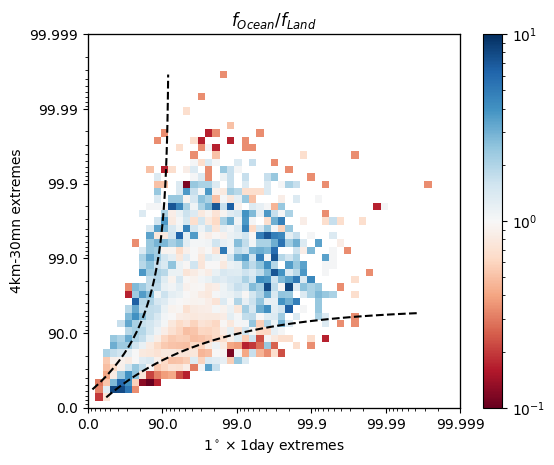

In [90]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z1 = bincount_land.T/Nland
Z2 = bincount_ocean.T/Nocean
Z_show = Z2/Z1
Z = jdist_prec.norm_density.T

title = r'$f_{Ocean}/f_{Land}$'
scale = 'log'
vbds = (1e-1,1e1)
cmap = plt.cm.RdBu

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z_show, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
# -- Branches

cont = measure.find_contours(Z, 1)

N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'ratio_flocean_fland_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()